## NTBS Aviation Analyses

* Student name: Tem Orederu and Eduardo Gonzalez 
* Student pace: Full time
* Scheduled project review date/time: August 25, 2023
* Instructor name: Joseph Mata


## Introduction

Our stakeholders are interested in purchasing and operating airplanes for commercial and private enterprises, and need information about the potential risks of aircrafts. Here, we conduct two sets of analyses using data collected by the National Transportation Safety Board. The dataset includes information about aircraft accidents from 1962 to 2023 in the United States and international waters. 

## Import Packages and Data

In [1]:
# Switch to determine whether running the notebook will generate new csvs and pngs (and overwrite previous versions) 
generate_csvs = 0
generate_pngs = 0

In [2]:
# Import necessary packages and suppress warnings
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

In [3]:
# Read in csv of cleaned data and preview data
df = pd.read_csv('data/data_clean.csv')
df.head()

,index,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Aircraft.Category,Total.Passengers,Total.Injured,Percent.Injured,Percent.Uninjured,Percent.Died,Event.Day,Event.Month,Event.Month.Name,Event.Year
0,0,ID,United States,Destroyed,Stinson,1083,1.0,Reciprocating,Personal,2.0,...,Unknown,2.0,2.0,100.000000,0.000000,100.0,24,10,October,1948
1,1,CA,United States,Destroyed,Piper,pa24180,1.0,Reciprocating,Personal,4.0,...,Unknown,4.0,4.0,100.000000,0.000000,100.0,19,7,July,1962
2,2,VA,United States,Destroyed,Cessna,172m,1.0,Reciprocating,Personal,3.0,...,Unknown,3.0,3.0,100.000000,0.000000,100.0,30,8,August,1974
3,3,CA,United States,Destroyed,Rockwell,112,1.0,Reciprocating,Personal,2.0,...,Unknown,2.0,2.0,100.000000,0.000000,100.0,19,6,June,1977
4,4,MA,United States,Substantial,Boeing,dc9,2.0,Turbo Fan,Unknown,0.0,...,Airplane,45.0,1.0,2.222222,97.777778,0.0,17,9,September,1979


## Visualize KPIs

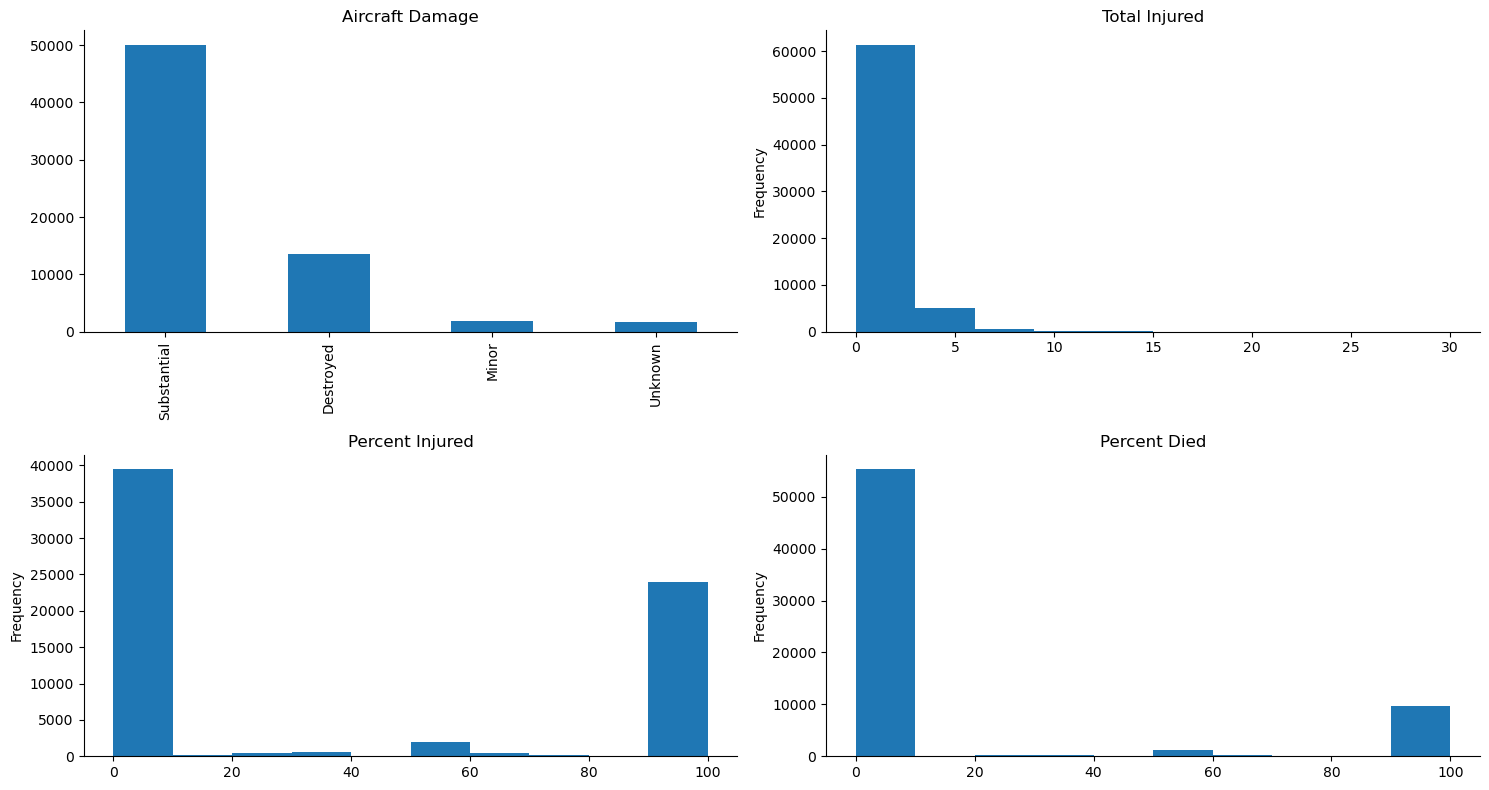

In [4]:
# Visualize distribution of key variables
fig, ax = plt.subplots(2,2, figsize = ((15,8)))

# Aircraft Damage
df['Aircraft.damage'].value_counts().plot.bar(ax=ax[0,0]);
ax[0, 0].set_title("Aircraft Damage")
ax[0, 0].set_xlabel("")

# Total Injured
df['Total.Injured'].plot.hist(ax=ax[0,1], range=[0,30])
ax[0, 1].set_title("Total Injured")
ax[0, 1].set_xlabel("")

# Percent Injured
df['Percent.Injured'].plot.hist(ax=ax[1,0])
ax[1, 0].set_title("Percent Injured")
ax[1, 0].set_xlabel("")

# Percent Died
df['Percent.Died'].plot.hist(ax=ax[1,1]);
ax[1, 1].set_title("Percent Died")
ax[1, 1].set_xlabel("")

plt.tight_layout()
sns.despine()

In [5]:
# Generate and print a list of all the popular makes in the dataset
# Note that the cleaned csv only includes incidents involving the top 50 makes 

popular_makes = list(df['Make'].value_counts().index)
print(f"top makes: {popular_makes}")

top makes: ['Cessna', 'Piper', 'Beech', 'Boeing', 'Bell', 'Robinson', 'Mooney', 'Grumman', 'Bellanca', 'Hughes', 'Air Tractor', 'Aeronca', 'Maule', 'Champion', 'Stinson', 'Cirrus', 'Luscombe', 'Aero Commander', 'De Havilland', 'Taylorcraft', 'Schweizer', 'North American', 'Aerospatiale', 'Airbus', 'Rockwell', 'Hiller', 'Enstrom', 'Ayres', 'Grumman American', 'Embraer', 'Eurocopter', 'Sikorsky', 'Swearingen', 'Ercoupe Eng & Research Corp', 'Fairchild', 'Lake', 'Waco', 'Mitsubishi', 'Aviat', 'Bombardier', 'GrummanSchweizer', 'Socata', 'Ryan', 'Helio', 'Learjet', 'Lockheed', 'Dehavilland', 'Globe', 'Weatherly', 'Wsk Pzl Mielec']


## Damage Index

Each row in the dataset contains information about an aircraft accident. In this section, we calculate a damage index to quantify how destructive the accidents were for a particular Make of aircraft. The damage index considers the ratio of planes of a particular Make that were destroyed in the incident, compared to the ratio of planes that with substantial damage and minor damage. 

We assume an exponential relationship between levels of aircraft damage, such that incidents with substantial damage are twice as bad as those with minor damage, but incidents with destroyed planes are four times as bad as those with minor damage. 

The damage index formula is as follows: (ratio destroyed x 4) + (ratio subtantial x 2) + (ratio minor x 1).

In [6]:
# Create a new df for calculating the damage index. In this dataframe, "Unknown" 
# values in the Aircraft Damage column will be randomly assigned a value. 
# Note that random assignments are weighted by the probability distribution of values in the known subset of data. 

# Find the indices of all unknown values in Aircraft Damage 
unk_indices = list(df.loc[df['Aircraft.damage'] == 'Unknown'].index)

# Calculate the probability of observing each value in the current dataset
damage_probs = df['Aircraft.damage'].value_counts()
damage_probs = damage_probs.drop('Unknown')
damage_probs = damage_probs / damage_probs.sum()

# Randomly generate new values for Aircraft Damage based on probabilities observed in known dataset 
rand_damage = np.random.choice(list(damage_probs.index), size = len(unk_indices), p = list(damage_probs))

# Create a new dataset with the new unknown values in Aircraft Damage replaced 
adj_df = df.copy()
adj_df['Aircraft.damage'].iloc[unk_indices] = rand_damage

In [7]:
# Create a df for the damage index 
di_df = pd.DataFrame(columns = ['Damage_Index', 'Num.Incidents.Make', 'Uninjured_P', 'Injured_P', 'Died_P'], )

# Get mean values for each Make of aircraft
pop_means_df = adj_df.groupby('Make').mean(numeric_only=True)

# Populate the damage index df using mean values for each Make of aircraft
for make in popular_makes:
    make_info = adj_df[adj_df['Make'] == make]['Aircraft.damage'].value_counts(normalize=True)

    # Some makes do not have 
    if 'Minor' not in make_info.index:
        make_info['Minor'] = 0

    damage_index = (make_info['Destroyed'] * 4) + (make_info['Substantial'] * 2) + (make_info['Minor'] * 1)

    # Add additional relevant info to damage index df 
    num_incidents = adj_df['Make'].value_counts()[make]
    make_stats = list(pop_means_df.loc[make].reindex(['Percent.Uninjured', 'Percent.Injured', 'Percent.Died']))
    di_df.loc[make] =[damage_index, num_incidents] + make_stats

In [8]:
# Adjust the damage index by penalizing Makes with too few datapoints (n) 
# All with makes with n < threshold are penalized 

threshold = 2000
penalty_rate = 0.25
di_df['Penalty'] = di_df['Num.Incidents.Make'].apply(lambda x: 1 + penalty_rate * np.log(threshold/x) if x < threshold else 1)
di_df['Adj_Damage_Index'] = di_df['Damage_Index'] * di_df['Penalty'] 
di_df.sort_values(by = 'Adj_Damage_Index')

,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index
Boeing,2.034962,2660.0,79.388114,14.484066,5.477698,1.000000,2.034962
Cessna,2.357476,26178.0,64.193118,35.692282,14.270196,1.000000,2.357476
Piper,2.438914,14365.0,58.658095,41.265330,18.640403,1.000000,2.438914
Bell,2.479769,2422.0,52.456202,47.378645,14.959588,1.000000,2.479769
Robinson,2.317903,1469.0,57.374631,42.285001,18.015657,1.077141,2.496709
Beech,2.551959,5129.0,54.037588,45.786939,26.107833,1.000000,2.551959
Mooney,2.536623,1297.0,48.496530,51.349268,25.872526,1.108273,2.811272
Air Tractor,2.346198,881.0,58.815740,41.184260,15.020810,1.204961,2.827077
Grumman,2.495660,1152.0,66.146612,33.853388,9.557252,1.137912,2.839841
Bellanca,2.441748,1030.0,55.072816,44.927184,18.988673,1.165897,2.846826


In [9]:
# Identify the top three makes based on the damage index 
top3makes = list(di_df.sort_values(by = 'Adj_Damage_Index').index[:3])
print(top3makes)

# Add new column to df indicating whether the incident involves a Make in the top 3
df['DI.Top3'] = df['Make'].apply(lambda x: x in top3makes)

['Boeing', 'Cessna', 'Piper']


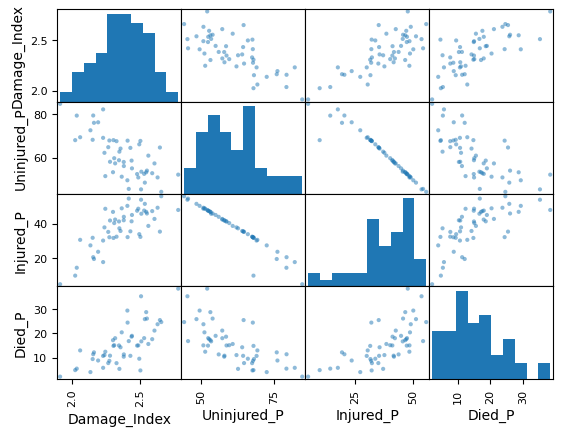

In [10]:
# Validate the damage index by plotting it against key metrics to observe relationships between the variables 
pd.plotting.scatter_matrix(di_df[['Damage_Index', 'Uninjured_P', 'Injured_P', 'Died_P']]);

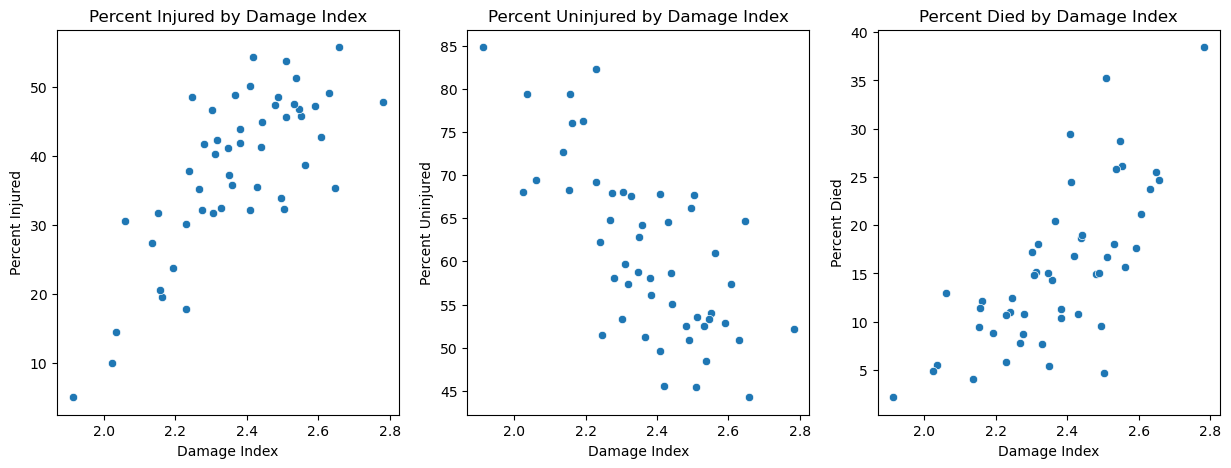

In [11]:
# Re-generate plots and save PNG

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=di_df['Damage_Index'], y=di_df['Injured_P'], ax=axes[0])
axes[0].set_title("Percent Injured by Damage Index")
axes[0].set_xlabel("Damage Index")
axes[0].set_ylabel("Percent Injured")

sns.scatterplot(x=di_df['Damage_Index'], y=di_df['Uninjured_P'], ax=axes[1])
axes[1].set_title("Percent Uninjured by Damage Index")
axes[1].set_xlabel("Damage Index")
axes[1].set_ylabel("Percent Uninjured")

sns.scatterplot(x=di_df['Damage_Index'], y=di_df['Died_P'], ax=axes[2])
axes[2].set_title("Percent Died by Damage Index")
axes[2].set_xlabel("Damage Index")
axes[2].set_ylabel("Percent Died")

if generate_pngs == 1:   
    fig.savefig("figs/di_corrs.png", bbox_inches = 'tight')

In [12]:
# Add damage index to df
df = df.join(di_df, how='outer', on='Make')

# Generate csv file of all data with damage indices
if generate_csvs == 1:
    df.to_csv('data/data_analyzed.csv', index_label = 'index')

## Prepare Model Data for Performance Calculation

Each of our top three Makes have low damage indices, however, the question still remains: when an aircraft is involved in an incident that results in damage, do the passengers leave the incident uninjured?

Now that we have identified the top three Makes, we will further narrow down our list of aircrafts by selecting the Models that have the highest performance, as defined by the ratio of incidents where passengers had positive outcomes. 

For planes that had substantial damage or were destroyed, performance was marked as positive if there were no fatalities. For planes that had minor damage, performance was marked as positive if there were no fatalities or injuries.

An overall performance score is generated by calculating the fraction of incidents that met the positive performance criteria over the total number of incidents for each Model.

In [13]:
# Create a df that includes incidents from only the top Makes 
df_top_makes = df[df['Make'].apply(lambda x: x in top3makes)].reset_index(drop=True)

In [14]:
# Print a list of all Models within the top Makes for visual inspection
for make in top3makes:
    print(f"{make}:")
    list_models = list(df[df['Make']==make]['Model'].unique())
    print(f"{list_models}\n")

Boeing:
['dc9', 'a75', '737222', 'dc3', 'dc1030', 'dc1010', 'a75n1', 'b7372h4', '727235', 'b727200', '707131b', 'dc982', 'kc135a', '707123b', '727200', 'e75', 'e75n1', 'dc915f', 'b75n1', 'dc861', 'dc3a', 'dc852', 'rb26c', 'dc3c', '75a', 'a75l300', 'b75', 'dc931', '727233', 'n2s1a75a', '727231', 'pt17', '737291', 'a75300n1', 'dc1030f', 'c47', '727', '727225a', '107', 'dc930', '737200', '707300', 'dc10', '727223', '707323c', 'dc951', '737201', '727225', 'a26c', 'dc854f', '747123', 'b737200', '767231', 'dc950', 'dc6a', 'b26c', 'dc910', '747', 'd75n1', '7372h4', '727222', 'dc871', 'dc863f', '727100', '72731h', 'b737222', 'dc1040', '234er', 'dc932', '727222a', 'b747', 'dc4c55b', 'dc7c', 'dc8', '727231a', 'ib75a', '747121', '767', 'bv107ii', 'pt13d', '727223b', 'b727023', '727247', '747200f', '72721', 'dc33c', 'dc980', '72715c', '727232', 'dc915', 'dc1030cf', '727224', 'b72790c', '747230', '72723', 'dc863', '72735', '72731', '720025', 'c118a', '747122', 'dc873', 'dc854', '737130', 'dc851', '

In [15]:
# Remove extraneous strings observed in visual inspection
to_replace = ['stearmane', 'stearman', 'boeing','probertsonstol','skywagon',\
               'kaerobat','psylane','citation','aerobat','hortonstol', 'rileysuper',\
               'aramvi','crileyturbinee','caravan','ector','skyhawk','turbocenturiont','undesignat']

for string in to_replace:
    df_top_makes['Model'] = df_top_makes['Model'].str.replace(string, '')

In [16]:
# If a particular Model has 20 or fewer incidents in our dataset, it will be difficult to make meaningful conclusions about it.
# Therefore, we drop rows from rare Models here. 

rare_models = df_top_makes['Model'].value_counts()
rare_models = rare_models[rare_models <= 20].index.tolist()

drop_rows = df_top_makes.loc[df_top_makes['Model'].apply(lambda x: x in rare_models)].index
df_top_makes = df_top_makes.drop(drop_rows).reset_index(drop=True)

In [17]:
# Re-examine models from the top three Makes 
for make in top3makes:
    print(f"{make}:")
    list_models = list(df_top_makes[df_top_makes['Make']==make]['Model'].unique())
    print(f"{list_models}\n")

Boeing:
['a75', 'dc3', 'dc1030', 'dc1010', 'a75n1', 'dc982', '727200', 'e75', 'b75n1', 'dc3c', 'dc931', 'pt17', '737200', 'dc951', '747', 'dc932', '767', '737300', '737', '369e', '757', 'md88', '757232', 'md82', 'md11', '500', '7377h4', 'a75n1pt17', '777']

Cessna:
['172m', '180', '140', 'r172k', '172', '152', '150l', '414a', '210l', '182', 't337g', '206', 'tr182', 'a185f', '210', 'tu206g', '172n', 'p210n', '182a', 'tu206f', 'u206', '210n', '310l', '414', 't210n', '310', '150m', '182p', '150', '170b', '180k', '177b', '177rg', '182e', '150h', '340a', '182n', '207', '172rg', '177', '182m', '152ii', 'a188b', '172h', '182l', '172p', 'p206', '150g', 'u206g', '150j', '182h', '182b', '310r', '402b', '185', '172k', '421b', '401', '421', '310d', '172a', '404', '172l', '421c', '210a', '310q', '182c', '170', 't210m', '140a', 'a152', '182rg', '310k', 't188c', '210d', '172g', '501', '182j', '120', '210m', '402c', '340', '180j', '172f', '175', '150f', '182k', 'a185e', 't210l', '170a', '205', '182g',

After removing extraneous strings and dropping rare Models, we still observe repeated Models (or variations of Models) in the data. Below, we further clean the Model column.

In [18]:
# Clean Boeing 
def clean_boeing(model_str):

    abr_str = model_str
    
    if model_str in ['dc982', 'md88', 'md82']:
        abr_str = 'md80'

    if model_str in ['dc1030', 'dc1010']:
        abr_str = 'md10'

    if model_str in ['dc982', 'dc931', 'dc951', 'dc932']:
        abr_str = 'md9'
    
    if model_str in ['a75', 'a75n1', 'e75', 'b75n1', 'a75n1pt17', 'pt17']:
        abr_str = 'm75'

    if model_str.startswith('7'):
        abr_str = model_str[:3]

    return abr_str

In [19]:
# Clean Cessna
def clean_cessna(x):
    y = ''
    for i in x:
        if i.isdigit():
            y += i
    x = y
    return x

In [20]:
# Clean Piper
def clean_piper(x):
    if len(x) > 3:
        x = 'pa'+x[2:4]

    if x == 'j3c':
        x = 'j3'

    if x == '180':
        x = 'pa18'
        
    return x

In [21]:
# Combine Boeing, Cessna, and Piper cleaning functions into a single function and apply it to the df 
make_model_df = df_top_makes[['Make','Model']]
make_model_df = make_model_df.drop_duplicates(keep='first')
make_model_df

def clean_top3(model_str): 
    make = make_model_df[make_model_df['Model'] == model_str]['Make'].values[0]

    if make == 'Boeing':
        return clean_boeing(model_str)
    
    if make == 'Cessna':
        return clean_cessna(model_str)

    if make == 'Piper':
        return clean_piper(model_str)

    if make == 'Robinson':
        return clean_robinson(model_str)

df_top_makes['Abr.Model'] = df_top_makes['Model'].apply(clean_top3)

In [22]:
# Re-examine models from the top3 makes 
for make in top3makes:
    print(f"{make}:")
    list_models = list(df_top_makes[df_top_makes['Make']==make]['Abr.Model'].unique())
    print(f"{list_models}\n")

Boeing:
['m75', 'dc3', 'md10', 'md9', '727', 'dc3c', '737', '747', '767', '369e', '757', 'md80', 'md11', '500', '777']

Cessna:
['172', 'pa18', '140', '152', '150', '414', '210', '182', '337', '206', '185', '310', '170', '180', '177', '340', '207', '188', '402', '421', '401', '404', '501', '120', '175', '205', '411', '195', '500', '303', '305', '190', '550', '441', '425', '320', '208', '525', '560']

Piper:
['pa24', 'pa28', 'pa34', 'pa22', 'pa31', 'pa23', 'pa38', 'pa32', 'pa18', 'pa36', 'pa60', 'pa20', 'pa25', 'pa30', 'pac6', 'pa11', 'pa44', 'j5a', 'pa12', 'pa16', 'pa14', 'j3', 'pa46']



## Calculate Performance for Each Model Within Top Three Makes 

For planes that had substantial damage or were destroyed, performance was marked as positive if there were no fatalities. For planes that had minor damage, performance was marked as positive if there were no fatalities or injuries.

An overall performance score is generated by calculating the fraction of incidents that met the positive performance criteria over the total number of incidents for each Model.

Note that we only consider incidents after 1989 when evaluating performance. 

In [23]:
# Overwrite main dataframe with info from only the top three Makes
df = df_top_makes.copy()

In [24]:
# Subset the df to select for incidents that meet the positive performance criteria
best_dest = df.loc[(df['Aircraft.damage'] == 'Destroyed') & (df['Percent.Died'] == 0) 
        & (df['Event.Year'] > 1989) & (df['Total.Passengers'] != 0)]

best_subs = df.loc[(df['Aircraft.damage'] == 'Substantial') & (df['Percent.Died'] == 0) 
         & (df['Event.Year'] > 1989) & (df['Percent.Injured'] == 0) & (df['Total.Passengers'] != 0)]

best_minor = df.loc[(df['Aircraft.damage'] == 'Minor') & (df['Percent.Died'] == 0) 
          & (df['Percent.Injured'] == 0) & (df['Event.Year'] > 1989) & (df['Total.Passengers'] != 0)]

In [25]:
# Calculate an overall performance score for each model by calculating 
# the fraction of incidents that met the positive performance criteria 
# divided by the total number of incidents for each model.

d_d = best_dest['Abr.Model'].value_counts().to_dict()
d_s = best_subs['Abr.Model'].value_counts().to_dict()
d_m = best_minor['Abr.Model'].value_counts().to_dict()
all_keys = set()
all_keys.update(d_d.keys())
all_keys.update(d_s.keys())
all_keys.update(d_m.keys())
r_d  = {}
for key in all_keys:
    r_d[key] = d_d.get(key, 0) + d_s.get(key, 0) + d_m.get(key, 0)
result_d = {}
for key in all_keys:
    denominator = df['Abr.Model'].value_counts().to_dict().get(key, 1)
       
    if denominator != 0:
        result_d[key] = r_d[key] / denominator
    else:
        result_d[key] = 0 

In [26]:
# Convert the performance dictionary into a pandas series 
model_performance = pd.Series(result_d)
model_performance.index.name = 'Abr.Model'
model_performance.name = 'Performance'
model_performance

Abr.Model
pa24    0.357243
188     0.377682
pac6    0.372624
pa18    0.544821
337     0.282353
          ...   
pa60    0.192308
md10    0.208955
pa14    0.431818
m75     0.497006
md11    0.472222
Name: Performance, Length: 75, dtype: float64

In [27]:
# Confirm there are no null values within the model performance series 
model_performance.isna().sum()

0

In [28]:
# Assemble Model means into a df
model_stats = df.groupby('Abr.Model')[['Percent.Uninjured', 'Percent.Injured', 'Percent.Died']].mean(numeric_only=True)
perf_df = model_stats.join(model_performance, how='left')
perf_df.head()

# Add performance measure to df
df = df.merge(model_performance, how='left', on='Abr.Model')

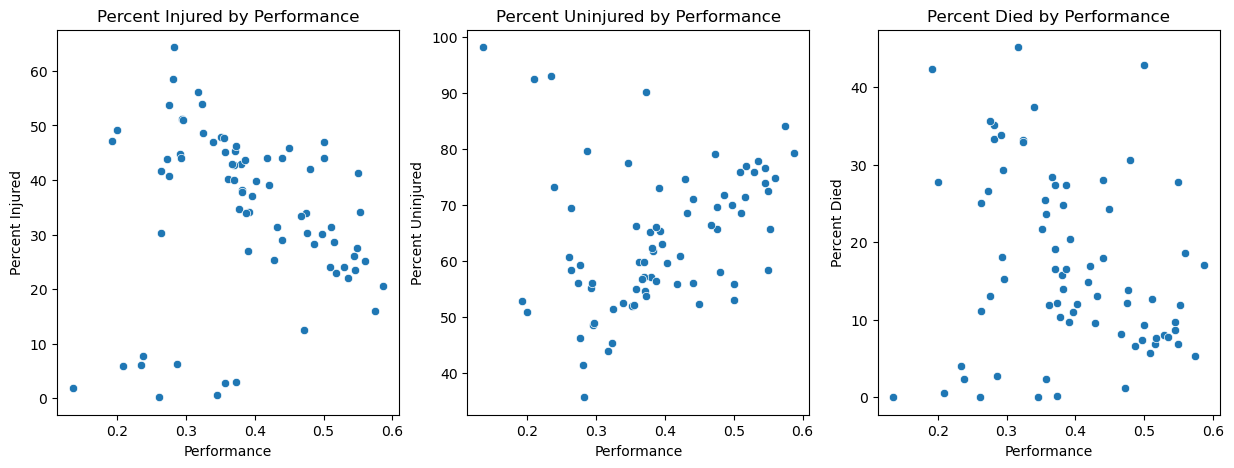

In [29]:
# Validate the performance measure by plotting it against key metrics to observe relationships between the variables 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=perf_df['Performance'], y=perf_df['Percent.Injured'], ax=axes[0])
axes[0].set_title("Percent Injured by Performance")
axes[0].set_xlabel("Performance")
axes[0].set_ylabel("Percent Injured")

sns.scatterplot(x=perf_df['Performance'], y=perf_df['Percent.Uninjured'], ax=axes[1])
axes[1].set_title("Percent Uninjured by Performance")
axes[1].set_xlabel("Performance")
axes[1].set_ylabel("Percent Uninjured")

sns.scatterplot(x=perf_df['Performance'], y=perf_df['Percent.Died'], ax=axes[2])
axes[2].set_title("Percent Died by Performance")
axes[2].set_xlabel("Performance")
axes[2].set_ylabel("Percent Died")

if generate_pngs == 1:   
    fig.savefig("figs/perf_corrs.png", bbox_inches = 'tight')

In [30]:
# Create a df with each model, make, it's performance score, it's corresponding make, and whether that make is top3 
make_model = model_stats.reset_index()
make_model = make_model.rename(columns={'index': 'Abr.Model'})
make_model = make_model.merge(df.loc[:,['Make', 'Model', 'Abr.Model']], how='left',on='Abr.Model')
make_model = make_model.merge(model_performance, how='left', on='Abr.Model')
make_model = make_model.drop_duplicates(subset='Abr.Model', keep='first').reset_index(drop=True)
make_model['Top3'] = make_model['Make'].apply(lambda x: x in top3makes)
make_model

,Abr.Model,Percent.Uninjured,Percent.Injured,Percent.Died,Make,Model,Performance,Top3
0,120,71.383648,28.616352,6.918239,Cessna,120,0.515723,True
1,140,71.788991,28.211009,6.651376,Cessna,140,0.486239,True
2,150,59.806552,40.130416,11.849609,Cessna,150l,0.361488,True
3,152,73.101626,26.898374,9.653794,Cessna,152,0.390650,True
4,170,75.896318,24.103682,7.982074,Cessna,170b,0.529070,True
...,...,...,...,...,...,...,...,...
70,pa38,69.549304,30.269208,11.116152,Piper,pa38112,0.263158,True
71,pa44,74.833333,25.166667,18.583333,Piper,pa44180,0.560000,True
72,pa46,58.387375,41.283678,27.708333,Piper,pa46310p,0.549342,True
73,pa60,52.820513,47.179487,42.307692,Piper,pa60,0.192308,True


In [31]:
# Filter for the top three Models within the top three Makes 
top_make_model = make_model[make_model['Top3']==True]

best_models = []

for make in top3makes:
    
    # Filter for all Models within one Make 
    subset = top_make_model[top_make_model['Make'] == make]
    
    # Extract best 3 Models within one Make (based on performance) 
    subset = subset.sort_values(by='Performance', ascending = False)['Abr.Model'][:3]

    best_models.extend(list(subset))

print(best_models)

['369e', 'm75', 'md11', '560', '195', '185', 'pa20', 'pa44', 'j5a']


In [32]:
# Add a new column to the df indicating whether the incident involved a top model
df['Top.Model'] = df['Abr.Model'].apply(lambda x: x in best_models)
df.head()

,index,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index,Abr.Model,Performance,Top.Model
0,1,CA,United States,Destroyed,Piper,pa24180,1.0,Reciprocating,Personal,4.0,...,2.438914,14365.0,58.658095,41.26533,18.640403,1.0,2.438914,pa24,0.357243,False
1,9,NM,United States,Substantial,Piper,pa28161,1.0,Reciprocating,Personal,0.0,...,2.438914,14365.0,58.658095,41.26533,18.640403,1.0,2.438914,pa28,0.370867,False
2,22,CA,United States,Minor,Piper,pa24180,1.0,Reciprocating,Personal,0.0,...,2.438914,14365.0,58.658095,41.26533,18.640403,1.0,2.438914,pa24,0.357243,False
3,31,OR,United States,Destroyed,Piper,pa28161,1.0,Reciprocating,Personal,4.0,...,2.438914,14365.0,58.658095,41.26533,18.640403,1.0,2.438914,pa28,0.370867,False
4,32,NV,United States,Destroyed,Piper,pa34200t,2.0,Reciprocating,Unknown,2.0,...,2.438914,14365.0,58.658095,41.26533,18.640403,1.0,2.438914,pa34,0.381466,False


## Explore features of top aircrafts

After identifying the top nine aircraft models, we followed-up with research to discover what the models have in common. We assembled this information into a csv file for further analysis and visualization. 

In [33]:
# Import data of the top aircraft information 
ac_info = pd.read_csv('data/top_aircraft_info.csv')

Our online research showed the majority of the models are light, general aviation airplanes. Below is a treeplot (generated with Tableau) that shows the distribution of aircraft types amongst the top models: 

<div style="text-align: center;">
<img src="imgs/top_model_categories.png" width="700"/>
</div>

We further explored the number of engines each aircraft has and the  passenger capacity of each aircraft. We plot this information on a parallel plot to highlight similarities and differences. 

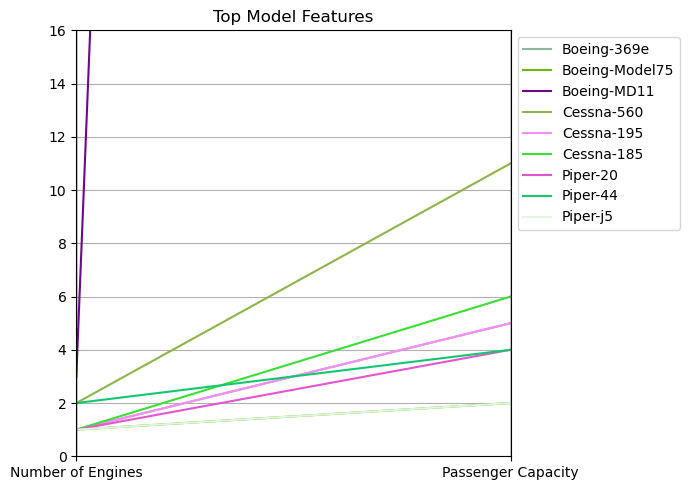

In [34]:
fig, ax = plt.subplots(figsize=(7,5))
pd.plotting.parallel_coordinates(ac_info[['Make.Model', 'Engine.Num', 'Passenger.Capacity']], 'Make.Model', ax=ax)

# 1. Move legend outside of the figure
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 2. Change x-axis labels
xlabels = ["Number of Engines", "Passenger Capacity"]
ax.set_title('Top Model Features')
ax.set_xticklabels(xlabels)
ax.set_ylim(bottom=0, top=16) 

plt.tight_layout()
plt.show()

if generate_pngs == 1:   
    fig.savefig("figs/model_features.png", bbox_inches = 'tight')

The parallel plot shows that most (4) of the top models have 1 engine, which is consistent with their designation as light aircrafts. As these are predominately smaller aircrafts, the passenger capacity is on the lower range, with most aircrafts having a capacity of 6 or fewer. Note that the Boeing MD11 has three engines, and a passenger capacity (410) that is off the scale compared to the remaining aircrafts.  

In [35]:
# Save data from top models as a csv
if generate_csvs == 1:
    df.to_csv('data/top_data_analyzed.csv', index_label = 'index')